## Imports

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# for resetting the output display and displaying image
import IPython.display as display

# optional: for image visualization on mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

# arrays, image viz, performance timing
import numpy as np
import PIL.Image
import time
import functools # not needed

## Utility Functions

In [2]:
# tensor to image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8) 
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1 
        tensor = tensor[0] 
    return PIL.Image.fromarray(tensor)

# loading any image
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape) 
    scale = max_dim / long_dim 

    new_shape = tf.cast(shape * scale, tf.int32) 
    
    img = tf.image.resize(img, new_shape) 
    img = img[tf.newaxis, :] 
    return img

# showing image from tensor/numpy/array
def imshow(image, title=None):
    if len(image.shape) > 3: 
        image = tf.squeeze(image, axis=0) 
    plt.imshow(image)
    if title:
        plt.title(title)

## Building the Model and Training

#### Content and Style Images

In [3]:
# content and style images
root = "C:/Users/VTSB/Desktop/CS Resources/AI Hands-On ML/images/Style Transfer Tutorial/"

content_path = root + "style_transfer_image_13.png"
style_path = root + "style_1.jpg"

#### Building the Feature Extraction Model and Extracting

In [4]:
# defining output layers and output layer counts
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [5]:
# building the CNN model with custom output
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [6]:
# defining style correlation fn
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) 
    return result/(num_locations)

In [7]:
# building the full model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
extractor = StyleContentModel(style_layers, content_layers)

In [8]:
# loading and extracting content and style from respective images
content_image = load_img(content_path)
style_image = load_img(style_path)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#### Training

In [9]:
# initializing it as a variable
image = tf.Variable(content_image)

In [10]:
# clipping images
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [11]:
# optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [12]:
# selected weights
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [13]:
# loss function
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [14]:
# 1 training step tf fn
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

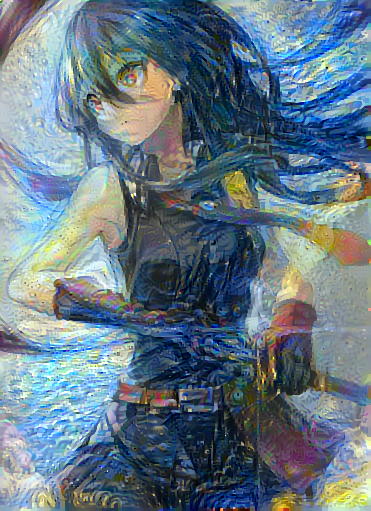

Train step: 1000
Total time: 1626.9


In [15]:
# training
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#### Saving Picture

In [16]:
file_name = root + 'stylized-image_1.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)